# (R) 비트코인의 daily/hourly data를 바탕으로

- 거품 측정 (AR(1)의 alpha > 1인지 확인) 및 비트코인이 일반 금융자산이 거품상태일 때와 유사한 양상을 보이는지 확인. 
- GJR-GARCH(1,1)의 gamma 확인 
- 거래량 데이터를 이용해 ARMAX/GARCHX 모델 수립
- daily/hourly data에 따라 차이가 있는지 확인


## 0. Initial settings. 

In [147]:
Sys.setlocale('LC_ALL', 'english')

r = getOption('repos')
r['CRAN'] <- 'http://cran.seoul.go.kr' # 서울시 빅데이터 캠퍼스
options(repos=r)

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

[1] "LC_COLLATE=English_United States.1252;LC_CTYPE=English_United States.1252;LC_MONETARY=English_United States.1252;LC_NUMERIC=C;LC_TIME=English_United States.1252"

In [148]:
require(forecast)
require(zoo)
require(fGarch)
require(rugarch)
require(psych)
require(aTSA)
require(fBasics)
require(tidyverse)
require(dplyr)

# 1. Import data and convert to zoo 

In [149]:
binance_d <- read.table("./mydata/Binance_BTCUSDT_d.csv", skip=1, sep=',', header=TRUE)
binance_h <- read.table("./mydata/Binance_BTCUSDT_1h.csv", skip=1, sep=',', header=TRUE)

In [150]:
binance_d <- select(binance_d, -c(Symbol))
binance_h <- select(binance_h, -c(Symbol))

In [151]:
binance_d <- read.zoo(binance_d, format='%Y-%m-%d')
head(binance_d)

              Open    High     Low   Close Volume.BTC Volume.USDT
2017-08-17 4469.93 4485.39 4200.74 4285.08     647.86     2812379
2017-08-18 4285.08 4371.52 3938.77 4108.37    1178.07     4994494
2017-08-19 4108.37 4184.69 3850.00 4139.98     371.15     1508239
2017-08-20 4139.98 4211.08 4032.62 4086.29     463.54     1915636
2017-08-21 4086.29 4119.62 3911.79 4016.00     685.12     2770592
2017-08-22 4016.00 4104.82 3400.00 4040.00     939.91     3648727

In [152]:
# binance_h <- read.zoo(binance_h, format='%Y-%m-%d %I-%p') # locale을 korea에서 us로 바꿔주니 해결. 
# 하지만 위의 코드는 이상하게 hour을 지워버림. 

binance_h$Date <- ymd_h(binance_h$Date) # lubridate로 대체
binance_h <- read.zoo(binance_h) 
head(binance_h)

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

                        Open     High     Low   Close Volume.BTC Volume.USDT
2017-08-17 04:00:00 16199.91 16199.91 4261.32 4308.83    44.5100   190952.85
2017-08-17 05:00:00  4308.83  4328.69 4291.37 4315.32    23.2300   100304.82
2017-08-17 06:00:00  4315.32  4345.45 4309.37 4324.35     7.2300    31282.31
2017-08-17 07:00:00  4324.35  4349.99 4287.41 4349.99     4.4400    19241.06
2017-08-17 08:00:00  4349.99  4377.85 4333.32 4360.69     0.9499     4139.70
2017-08-17 09:00:00  4360.69  4445.78 4360.00 4444.00    10.7600    47219.36

In [153]:
typeof(binance_d)

[1] "double"

In [154]:
typeof(binance_h)

[1] "double"

In [155]:
binance_d_before <- binance_d[index(binance_d) < as.Date("2018-01-10")]
binance_d_after <- binance_d[index(binance_d) >= as.Date("2018-01-10")]

binance_h_before <- binance_h[index(binance_h) < as.Date("2018-01-10")]
binance_h_after <- binance_h[index(binance_h) >= as.Date("2018-01-10")]

In [167]:
print(c(
    nrow(binance_d_before),
    nrow(binance_d_after),
    nrow(binance_h_before),
    nrow(binance_h_after)
))

[1]   146   500  3500 12275


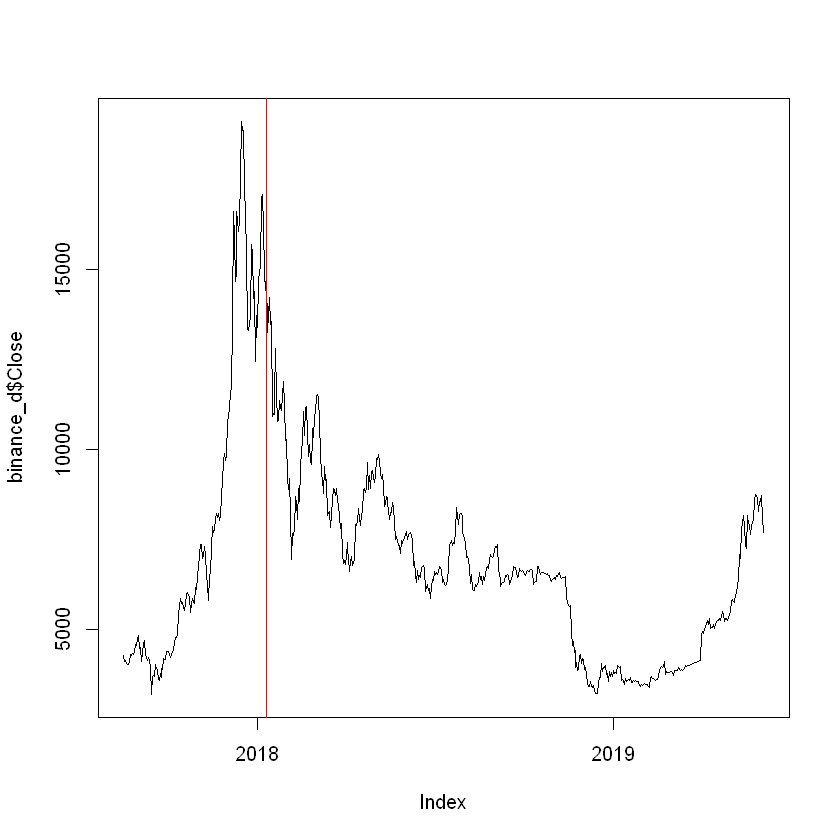

In [184]:
plot(binance_d$Close)
abline(v=as.Date("2018-01-10"), col='red', cex=100)

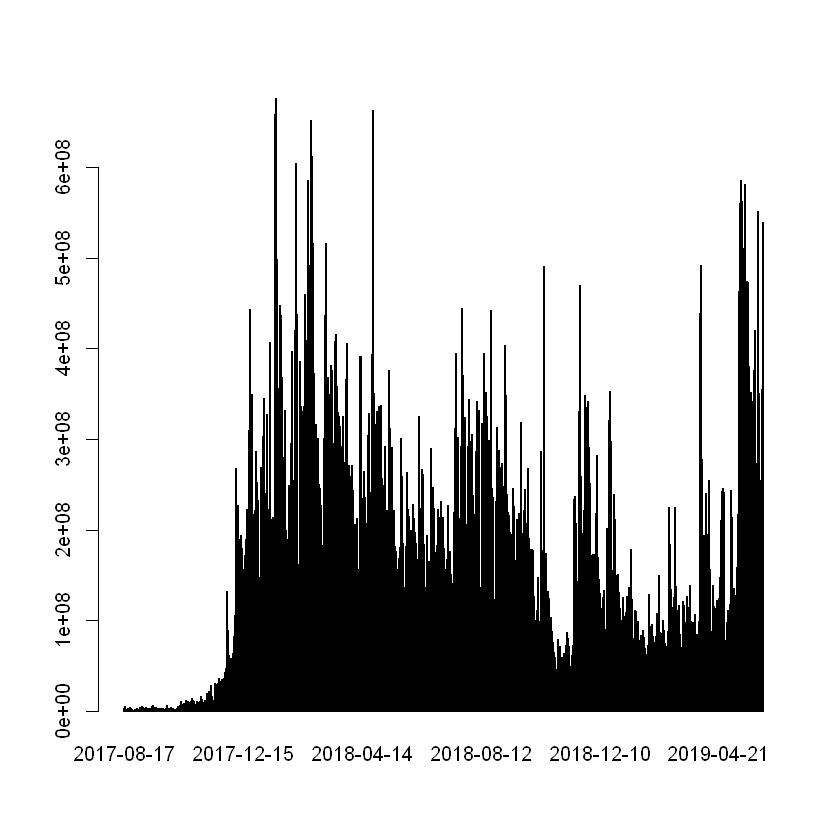

In [185]:
barplot(binance_d$Volume.USDT)
abline(v=as.Date("2018-01-10"), col='red', cex=100)

# 2. Check stationarity - unit root test

Using ADF(Augmented Dickey-Fuller test)

H0: B = 1 (unit root)

H1: B < 1  

### 1. Original price data - expected to be non-stationary

In [198]:
adf.test(matrix(binance_d$Close), nlag=5)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -0.433   0.519
[2,]   1 -0.488   0.503
[3,]   2 -0.497   0.501
[4,]   3 -0.494   0.502
[5,]   4 -0.399   0.529
Type 2: with drift no trend 
     lag   ADF p.value
[1,]   0 -1.87   0.379
[2,]   1 -2.01   0.325
[3,]   2 -2.02   0.320
[4,]   3 -2.03   0.317
[5,]   4 -1.88   0.375
Type 3: with drift and trend 
     lag   ADF p.value
[1,]   0 -2.18   0.498
[2,]   1 -2.34   0.431
[3,]   2 -2.36   0.425
[4,]   3 -2.38   0.416
[5,]   4 -2.24   0.475
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


As expected, we cannot reject H0: there exist a unit root 

Therefore the original price data is non-stationary. 

It is unnecessary to perform this on hourly/before/after data

### 2. log-log differenced price data 

** From now on, all _before, _after data will be replaced to log-log differenced data

In [189]:
binance_d_before <- diff(log(binance_d_before)*100, lag=1)
binance_d_after <- diff(log(binance_d_after)*100, lag=1)
binance_h_before <- diff(log(binance_h_before)*100, lag=1)
binance_h_after <- diff(log(binance_h_after)*100, lag=1)

In [194]:
adf.test(matrix(binance_d_before$Close), nlag=5)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -11.07    0.01
[2,]   1  -7.82    0.01
[3,]   2  -6.68    0.01
[4,]   3  -6.25    0.01
[5,]   4  -4.99    0.01
Type 2: with drift no trend 
     lag    ADF p.value
[1,]   0 -11.27    0.01
[2,]   1  -8.04    0.01
[3,]   2  -6.95    0.01
[4,]   3  -6.62    0.01
[5,]   4  -5.35    0.01
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0 -11.24    0.01
[2,]   1  -8.02    0.01
[3,]   2  -6.94    0.01
[4,]   3  -6.60    0.01
[5,]   4  -5.34    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


In [195]:
adf.test(matrix(binance_d_after$Close), nlag=5)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -23.47    0.01
[2,]   1 -14.98    0.01
[3,]   2 -11.58    0.01
[4,]   3 -10.88    0.01
[5,]   4  -9.16    0.01
Type 2: with drift no trend 
     lag    ADF p.value
[1,]   0 -23.47    0.01
[2,]   1 -14.99    0.01
[3,]   2 -11.59    0.01
[4,]   3 -10.89    0.01
[5,]   4  -9.17    0.01
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0 -23.62    0.01
[2,]   1 -15.14    0.01
[3,]   2 -11.76    0.01
[4,]   3 -11.08    0.01
[5,]   4  -9.35    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


In [196]:
adf.test(matrix(binance_h_before$Close), nlag=5)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag   ADF p.value
[1,]   0 -66.1    0.01
[2,]   1 -46.0    0.01
[3,]   2 -38.0    0.01
[4,]   3 -33.3    0.01
[5,]   4 -29.6    0.01
Type 2: with drift no trend 
     lag   ADF p.value
[1,]   0 -66.2    0.01
[2,]   1 -46.0    0.01
[3,]   2 -38.1    0.01
[4,]   3 -33.4    0.01
[5,]   4 -29.7    0.01
Type 3: with drift and trend 
     lag   ADF p.value
[1,]   0 -66.2    0.01
[2,]   1 -46.0    0.01
[3,]   2 -38.1    0.01
[4,]   3 -33.4    0.01
[5,]   4 -29.7    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


In [197]:
adf.test(matrix(binance_h_after$Close), nlag=5)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -116.3    0.01
[2,]   1  -85.6    0.01
[3,]   2  -67.4    0.01
[4,]   3  -56.3    0.01
[5,]   4  -50.1    0.01
Type 2: with drift no trend 
     lag    ADF p.value
[1,]   0 -116.3    0.01
[2,]   1  -85.6    0.01
[3,]   2  -67.4    0.01
[4,]   3  -56.3    0.01
[5,]   4  -50.1    0.01
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0 -116.4    0.01
[2,]   1  -85.7    0.01
[3,]   2  -67.5    0.01
[4,]   3  -56.3    0.01
[5,]   4  -50.1    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 
